## Denoise Validation

In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
import umap


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

from scprint.utils import utils
from scprint.tasks import Embedder


from scprint.tasks import Denoiser

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
2024-04-19 17:51:17,753:INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-04-19 17:51:17,868:INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-04-19 17:51:17,957:INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-04-19 17:51:18,044:INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-04-19 17:51:18,131:INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-04-19 17:51:18,308:INFO - Downloading data from `https://omnipathdb.org/about?format=text`


In [2]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [3]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad') 

In [6]:
sc.pp.neighbors(adata, n_neighbors=15)

In [4]:
from scdataloader.data import SimpleAnnDataset
from scdataloader import Collator
from scprint.model import utils
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer


In [5]:
from scprint.tasks.cell_emb import compute_corr
from scipy.stats import spearmanr
import os

In [80]:
os.system('rm collator_output.txt')

0

In [81]:
adataset = SimpleAnnDataset(
    adata[:40], obs_to_output=["organism_ontology_term_id"]
)
sub = adata[0, (np.asarray(adata.X.sum(0))[0] > 0)][:, : 4_000]
genelist = adata.var[np.asarray(adata.X.sum(0))[0] > 0].index.tolist()
col = Collator(
    organisms=[adata.obs['organism_ontology_term_id'][0]],
    valid_genes=model.genes,
    how="some",
    genelist=genelist[: 4_000],
    #downsample=0.4,
    #save_output=True,
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=10,
    num_workers=1,
    shuffle=False,
)
model.predict_mode="denoise"
model.predict_depth_mult=5

trainer = Trainer(precision='16-mixed')
trainer.predict(model, dataloader)
reco = utils.zinb_sample(
    model.expr_pred[0],
    model.expr_pred[1],
    model.expr_pred[2],
)

/tmp/ipykernel_477414/1340988972.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[adata.obs['organism_ontology_term_id'][0]],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

# trying out my own true denoising

In [60]:
noisy = np.loadtxt("collator_output.txt")
true = adata.X[:40,(np.asarray(adata.X.sum(0))[0] > 0)][:,:20_000][:, sub.var.index.isin(model.genes)]

In [61]:
reco.sum(1), noisy.sum(1), true.sum(1), reco.shape, noisy.shape, true.shape

(tensor([ 398.,  592.,  290.,  539., 1646.,  852.,  763.,  549.,  886.,  283.,
          768.,  178.,  533.,  493.,  739., 1195.,  213.,  636.,  718.,  281.,
          268.,  626.,  683., 1164.,  631.,  353.,  355.,  266.,  807.,  716.,
          661., 1044.,  749.,  494.,  532.,  885.,  479.,  482.,  855.,  282.],
        device='cuda:0'),
 array([105., 126.,  53., 115., 198., 251., 148., 129., 172.,  61., 157.,
         38., 153., 109., 142., 125.,  52.,  93., 175.,  56.,  63., 151.,
        121., 227., 132.,  71., 100.,  64., 141., 183., 152., 145., 143.,
        117., 121., 146.,  75.,  92., 203.,  69.]),
 matrix([[171.],
         [209.],
         [ 93.],
         [193.],
         [343.],
         [379.],
         [236.],
         [201.],
         [270.],
         [ 92.],
         [261.],
         [ 67.],
         [253.],
         [170.],
         [250.],
         [216.],
         [ 99.],
         [135.],
         [299.],
         [ 94.],
         [100.],
         [218.],
         

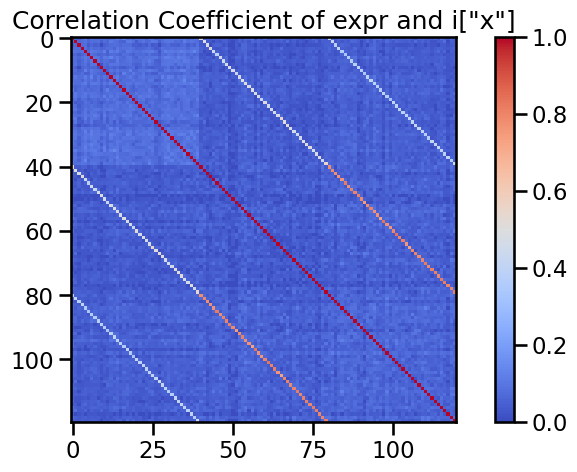

In [67]:
corr_coef, p_value = spearmanr(np.vstack([reco.cpu().numpy(), noisy, true.todense()]).T)
corr_coef[p_value > 0.05] = 0
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap="coolwarm", interpolation="none", vmin=0, vmax=1)
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()

In [66]:
np.mean(corr_coef[40:80, :40].diagonal()), np.mean(corr_coef[80:120, :40].diagonal()), np.mean(corr_coef[80:120, 40:80].diagonal())

(0.03606212441886689, 0.04480912280560969, 0.7896522815147087)

# using the initial method of averaging across  neightbors

In [70]:
avgd = np.vstack(
    [
        np.asarray(
            adata.X[adata.obsp["connectivities"][i].nonzero()[1]].sum(0)
        )[0]
        for i in range(40)
    ]
)[:,(np.asarray(adata.X.sum(0))[0] > 0)][:,:20_000][:, sub.var.index.isin(model.genes)]

In [71]:
true = adata.X[:40,(np.asarray(adata.X.sum(0))[0] > 0)][:,:20_000][:, sub.var.index.isin(model.genes)]

# we do not correlate with avgd but neither does the trye expr

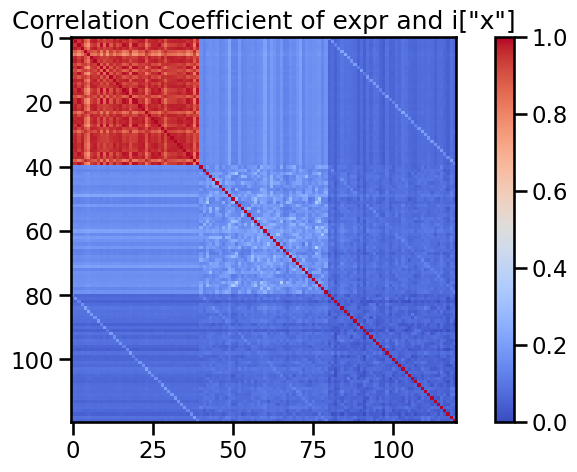

In [75]:
corr_coef, p_value = spearmanr(np.vstack([model.expr_pred[0].cpu().numpy(), avgd, true.todense()]).T)
#corr_coef[p_value > 0.05] = 0
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap="coolwarm", interpolation="none", vmin=0, vmax=1)
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()

In [76]:
np.mean(corr_coef[40:80, :40].diagonal()), np.mean(corr_coef[80:120, :40].diagonal()), np.mean(corr_coef[80:120, 40:80].diagonal())

(0.1619069129612746, 0.17491121481813826, 0.11635532935968995)

In [ ]:
cell emb true expr,
umap 

In [ ]:
adataset = SimpleAnnDataset(
    adata[:10], obs_to_output=["organism_ontology_term_id"]
)
sub = adata[0, (np.asarray(adata.X.sum(0))[0] > 0)][:, : 20_000]
genelist = adata.var[np.asarray(adata.X.sum(0))[0] > 0].index.tolist()
col = Collator(
    organisms=[adata.obs['organism_ontology_term_id'][0]],
    valid_genes=model.genes,
    how="some",
    genelist=genelist[: 20_000],
)
dataloader = DataLoader(
    adataset,
    collate_fn=col,
    batch_size=10,
    num_workers=1,
    shuffle=False,
)
emb.trainer.predict(model, dataloader)

reco = utils.zinb_sample(
    emb.model.expr_pred[0],
    emb.model.expr_pred[1],
    emb.model.expr_pred[2],
)

In [8]:
denoise = Denoiser(
    model,
    batch_size=20,
    max_len=5000,
    plot_corr_size=120,
    doplot=True,
    predict_depth_mult=5
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

hey
hey
hey
hey
hey
hey
AnnData object with n_obs × n_vars = 120 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

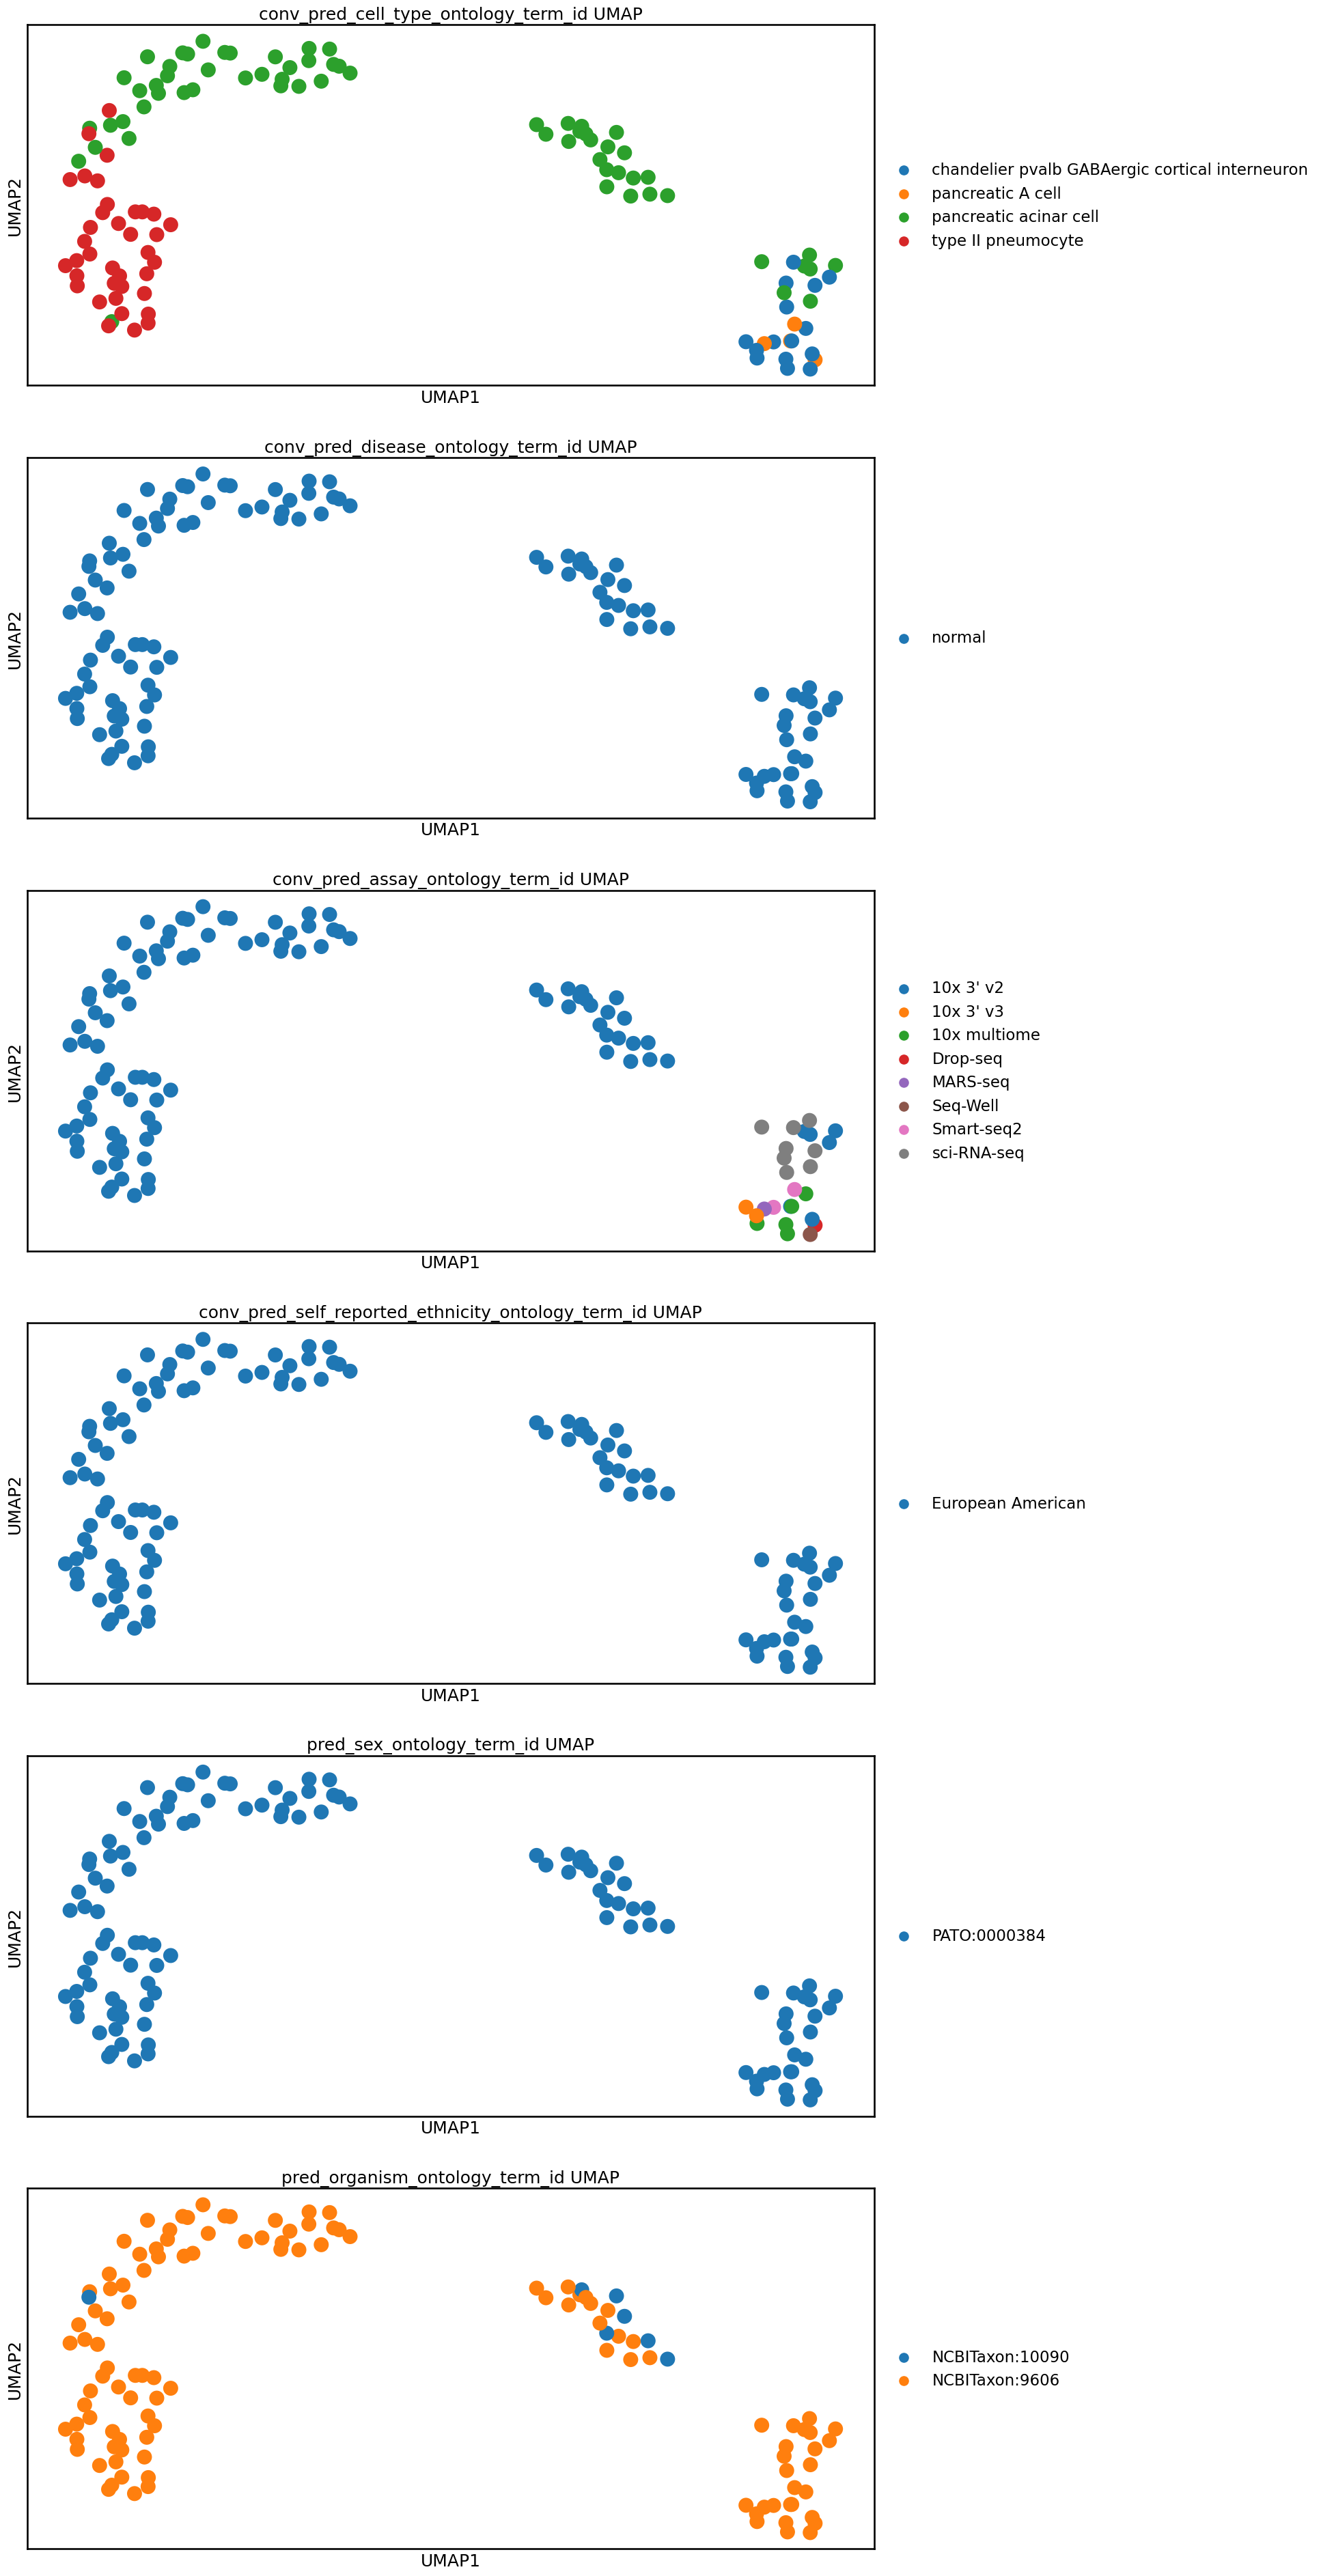

couldn't log to tensorboard
couldn't log to wandb


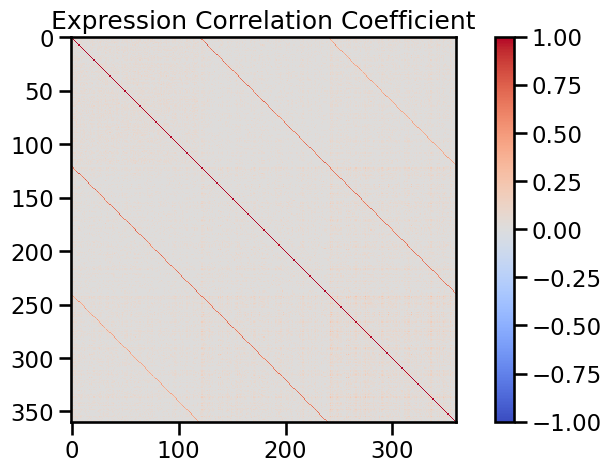

{'reco_self_noisy': 0.6435041332933241,
 'reco_self_full': 0.4277910053000129,
 'reco_noisy_full': 0.656661478333191}

In [10]:
denoise(adata)